In [11]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import os

In [12]:
token_path = "Flickr8k.token.txt"
train_images_path = "Flickr_8k.trainImages.txt"
test_images_path = "Flickr_8k.testImages.txt"
images_path = r"C:\Users\Abhishta\Desktop\Image Caption Generator\Flicker8K_Dataset"

In [13]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path):
    
        # caption has format-> 109202801_c6381eef15.jpg#0  Two draft horses pull a cart through the snow .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

# call the function
captions_dict = load_caption_file("captions.txt")

In [14]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [15]:
# delete unwanted 
del captions_dict

In [16]:
print('"' + list(new_captions_dict.keys())[0] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[0]])

"image,caption" : startseq  endseq


In [17]:
len(new_captions_dict)

8092

In [18]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(images_path) if image.split('.')[0] in image_index ]
caption_images_list[0]

'1000268201_693b08cb0e'

In [19]:
train_validate_images = caption_images_list[0:8081]  
test_images = caption_images_list[8081:8091]
test_images

['98377566_e4674d1ebd',
 '985067019_705fe4a4cc',
 '987907964_5a06a63609',
 '989754491_7e53fb4586',
 '989851184_9ef368e520',
 '990890291_afc72be141',
 '99171998_7cc800ceef',
 '99679241_adc853a5c0',
 '997338199_7343367d7f',
 '997722733_0cb5439472']

In [20]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG19()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
#         print('>%s' % name)
        

    return features

In [22]:
# extracting image features for train_validate_images
train_validate_features = extract_features(images_path, train_validate_images) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

1000268201_693b08cb0e : [[0.        1.8022311 0.        ... 0.        0.        0.       ]]


In [24]:
len(train_validate_features)

8081

In [25]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

In [26]:
# load libraries
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [27]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):
        
         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

In [28]:
list(train_validate_image_caption.values())[1]

'startseq black dog and spotted dog are fighting endseq'

In [29]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):
    
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images 
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]  

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)
               
    return np.array(x1), np.array(x2), np.array(y)

In [30]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [31]:
len(train_x1)

71355

In [32]:
len(validate_x1)

10160

In [33]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 256)      1143296     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [34]:
plot_model(model, to_file='model.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [35]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [39]:
# define checkpoint callback
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

callbacks = [
             ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss') ]

In [40]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (71355, 4096)
shape of train_x2  (71355, 30)
shape of train_y  (71355, 4466)

shape of validate_x1  (10160, 4096)
shape of validate_x2  (10160, 30)
shape of validate_y  (10160, 4466)


In [41]:
# fit model
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,            
                    epochs = 20,            
                    callbacks = callbacks, 
                    validation_data=([validate_x1, validate_x2], validate_y))

Epoch 1/20
2230/2230 [==============================] - 251s 111ms/step - loss: 5.0537 - val_loss: 4.4831


C:\Users\Abhishta\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/20
2230/2230 [==============================] - 253s 113ms/step - loss: 4.2247 - val_loss: 4.2939
Epoch 3/20
2230/2230 [==============================] - 246s 111ms/step - loss: 3.8860 - val_loss: 4.3077
Epoch 4/20
2230/2230 [==============================] - 240s 108ms/step - loss: 3.6563 - val_loss: 4.2871
Epoch 5/20
2230/2230 [==============================] - 239s 107ms/step - loss: 3.4822 - val_loss: 4.3396
Epoch 6/20
2230/2230 [==============================] - 239s 107ms/step - loss: 3.3385 - val_loss: 4.4886
Epoch 7/20
2230/2230 [==============================] - 240s 108ms/step - loss: 3.2149 - val_loss: 4.6050
Epoch 8/20
2230/2230 [==============================] - 240s 108ms/step - loss: 3.1086 - val_loss: 4.6444
Epoch 9/20
2230/2230 [==============================] - 249s 111ms/step - loss: 3.0110 - val_loss: 4.7894
Epoch 10/20
2230/2230 [==============================] - 246s 110ms/step - loss: 2.9240 - val_loss: 5.0182
Epoch 11/20
2230/2230 [======================

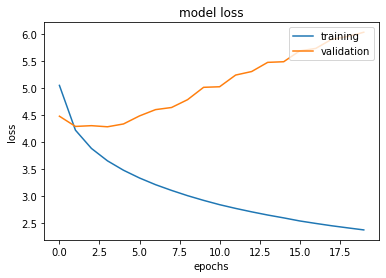

In [53]:
# plot training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [43]:
# saving the model with last parameter 
model.save('./latest_model.h5')

C:\Users\Abhishta\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [44]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG19()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [45]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [48]:
import tensorflow
tensorflow.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [49]:
from keras.models import load_model
# load the model
modl = load_model('./latest_model.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+train_validate_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq man in black shirt is sitting on bench in front of christmas tree endseq

Actual caption ->  startseq child in pink dress is climbing up set of stairs in an entry way endseq
*********************************************************************

Predicted caption ->  startseq black and white dog is jumping in the air endseq

Actual caption ->  startseq black dog and spotted dog are fighting endseq
*********************************************************************

Predicted caption ->  startseq boy in blue shirt is jumping off the street endseq

Actual caption ->  startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
*********************************************************************

Predicted caption ->  startseq black and white dog is jumping in the air endseq

Actual caption ->  startseq man lays on bench while his dog sits by him endseq
****************************************************************

In [50]:
# load the model
modl = load_model('model-ep01-loss5.054-val_loss4.483.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq lift brown on goggles and in bicycle endseq

Actual caption ->  startseq brown and white dogs lift their ears and look through fence endseq
*********************************************************************

Predicted caption ->  startseq man and boy grass on surrounded white in in in in in in in in in in in in in in in in in in in in in in in

Actual caption ->  startseq boy goes down an inflatable slide endseq
*********************************************************************

Predicted caption ->  startseq his brown on goggles and in bicycle endseq

Actual caption ->  startseq brown and white dog chasing black and white dog through the grass endseq
*********************************************************************

Predicted caption ->  startseq dogs and in fence and in fence endseq

Actual caption ->  startseq girl in pool wearing goggles and surrounded by other children endseq
*****************************************************************

In [51]:
# load the model
modl = load_model('model-ep02-loss4.225-val_loss4.294.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq lift brown on goggles by in bicycle endseq

Actual caption ->  startseq brown and white dogs lift their ears and look through fence endseq
*********************************************************************

Predicted caption ->  startseq man and boy grass on surrounded white in

Actual caption ->  startseq boy goes down an inflatable slide endseq
*********************************************************************

Predicted caption ->  startseq lift brown on goggles by in sidewalk endseq

Actual caption ->  startseq brown and white dog chasing black and white dog through the grass endseq
*********************************************************************

Predicted caption ->  startseq dogs and face grass on wearing and in fence endseq

Actual caption ->  startseq girl in pool wearing goggles and surrounded by other children endseq
*********************************************************************

Predicted caption ->  startseq his brown on gog

In [52]:
# load the model
modl = load_model('model-ep04-loss3.656-val_loss4.287.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq lift brown on goggles by in bicycle endseq

Actual caption ->  startseq brown and white dogs lift their ears and look through fence endseq
*********************************************************************

Predicted caption ->  startseq man and slide grass on around white in roll endseq

Actual caption ->  startseq boy goes down an inflatable slide endseq
*********************************************************************

Predicted caption ->  startseq his dog stands brown on goggles by in bicycle endseq

Actual caption ->  startseq brown and white dog chasing black and white dog through the grass endseq
*********************************************************************

Predicted caption ->  startseq man and slide

Actual caption ->  startseq girl in pool wearing goggles and surrounded by other children endseq
*********************************************************************

Predicted caption ->  startseq brown on goggles by in roll endseq